# DCGAN model Architecture
------------------------------------------

![nn](data/DCGAN_Model.png)

In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import pandas as pd
import seaborn as sns
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# 이미지 샘플 확인하기

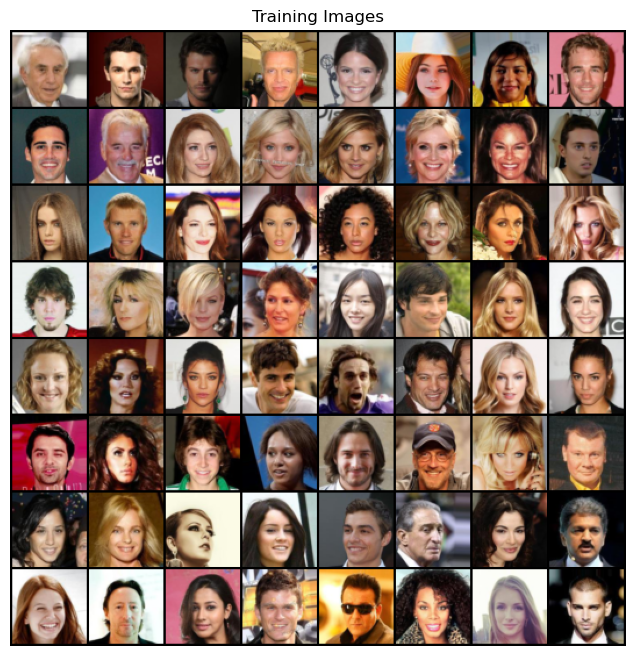

In [9]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataroot= 'data/img_align_celeba'
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

one_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(one_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# 가중치 초기화

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # 논문에서 std=0.02 언급
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

In [11]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Train

In [15]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [34]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("학습을 시작합니다...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(tqdm(dataloader)):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    # Output training stats        
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs,errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

학습을 시작합니다...


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:48<00:00, 14.62it/s]


[0/20]	Loss_D: 0.3784	Loss_G: 2.7059	D(x): 0.8392	D(G(z)): 0.1538 / 0.0950


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 14.98it/s]


[1/20]	Loss_D: 0.6489	Loss_G: 4.3357	D(x): 0.8939	D(G(z)): 0.3775 / 0.0195


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:46<00:00, 14.91it/s]


[2/20]	Loss_D: 0.5400	Loss_G: 1.8700	D(x): 0.6929	D(G(z)): 0.1141 / 0.1899


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 15.04it/s]


[3/20]	Loss_D: 0.6198	Loss_G: 1.9937	D(x): 0.7576	D(G(z)): 0.2459 / 0.1639


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:46<00:00, 14.80it/s]


[4/20]	Loss_D: 0.5297	Loss_G: 3.3238	D(x): 0.8595	D(G(z)): 0.2808 / 0.0471


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 15.05it/s]


[5/20]	Loss_D: 0.3441	Loss_G: 2.9667	D(x): 0.8726	D(G(z)): 0.1655 / 0.0637


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:43<00:00, 15.22it/s]


[6/20]	Loss_D: 0.5823	Loss_G: 3.4669	D(x): 0.8284	D(G(z)): 0.2760 / 0.0468


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 15.01it/s]


[7/20]	Loss_D: 0.3290	Loss_G: 2.9184	D(x): 0.8571	D(G(z)): 0.1404 / 0.0702


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 14.98it/s]


[8/20]	Loss_D: 0.3328	Loss_G: 3.7452	D(x): 0.9279	D(G(z)): 0.2077 / 0.0320


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 15.01it/s]


[9/20]	Loss_D: 2.7984	Loss_G: 0.1087	D(x): 0.1256	D(G(z)): 0.0190 / 0.9083


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:44<00:00, 15.20it/s]


[10/20]	Loss_D: 0.3079	Loss_G: 2.5003	D(x): 0.8562	D(G(z)): 0.1160 / 0.1159


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 15.07it/s]


[11/20]	Loss_D: 0.3331	Loss_G: 3.3816	D(x): 0.8821	D(G(z)): 0.1621 / 0.0469


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 14.96it/s]


[12/20]	Loss_D: 0.1930	Loss_G: 3.3629	D(x): 0.8780	D(G(z)): 0.0488 / 0.0509


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:46<00:00, 14.81it/s]


[13/20]	Loss_D: 0.2426	Loss_G: 3.6582	D(x): 0.8327	D(G(z)): 0.0328 / 0.0447


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:44<00:00, 15.14it/s]


[14/20]	Loss_D: 0.1129	Loss_G: 3.4578	D(x): 0.9364	D(G(z)): 0.0406 / 0.0507


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:46<00:00, 14.85it/s]


[15/20]	Loss_D: 0.2536	Loss_G: 4.4462	D(x): 0.9438	D(G(z)): 0.1560 / 0.0156


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 15.05it/s]


[16/20]	Loss_D: 0.1983	Loss_G: 4.2185	D(x): 0.9445	D(G(z)): 0.1150 / 0.0245


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:46<00:00, 14.93it/s]


[17/20]	Loss_D: 0.3564	Loss_G: 6.9422	D(x): 0.9952	D(G(z)): 0.2499 / 0.0015


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:45<00:00, 14.98it/s]


[18/20]	Loss_D: 0.1056	Loss_G: 4.6795	D(x): 0.9674	D(G(z)): 0.0658 / 0.0165


100%|███████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [01:46<00:00, 14.90it/s]

[19/20]	Loss_D: 0.8084	Loss_G: 1.1941	D(x): 0.5296	D(G(z)): 0.0073 / 0.4254


# Result Visualization

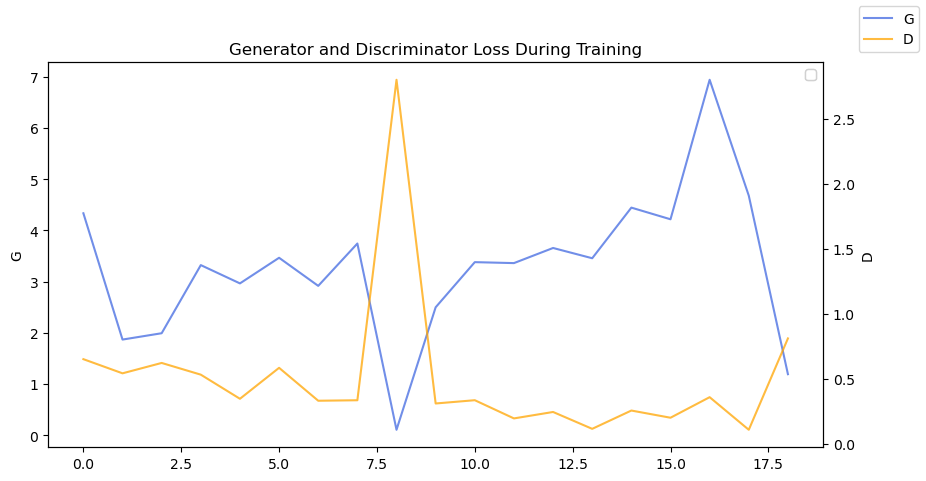

In [35]:
import pandas as pd
import seaborn as sns
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
df = pd.DataFrame({'G': G_losses[1:], 'D': D_losses[1:]})
ax1 = sns.lineplot(data=df, x=df.index, y='G', label='G', color='royalblue', alpha=.75)
ax2 = ax1.twinx()
sns.lineplot(data=df, x=df.index, y='D', label='D', color='orange', alpha=.75, ax=ax2)
for ax in [ax1, ax2]:
#     ax.set_ylim(bottom=0.)
    ax.legend([])
ax1.figure.legend()
plt.show()

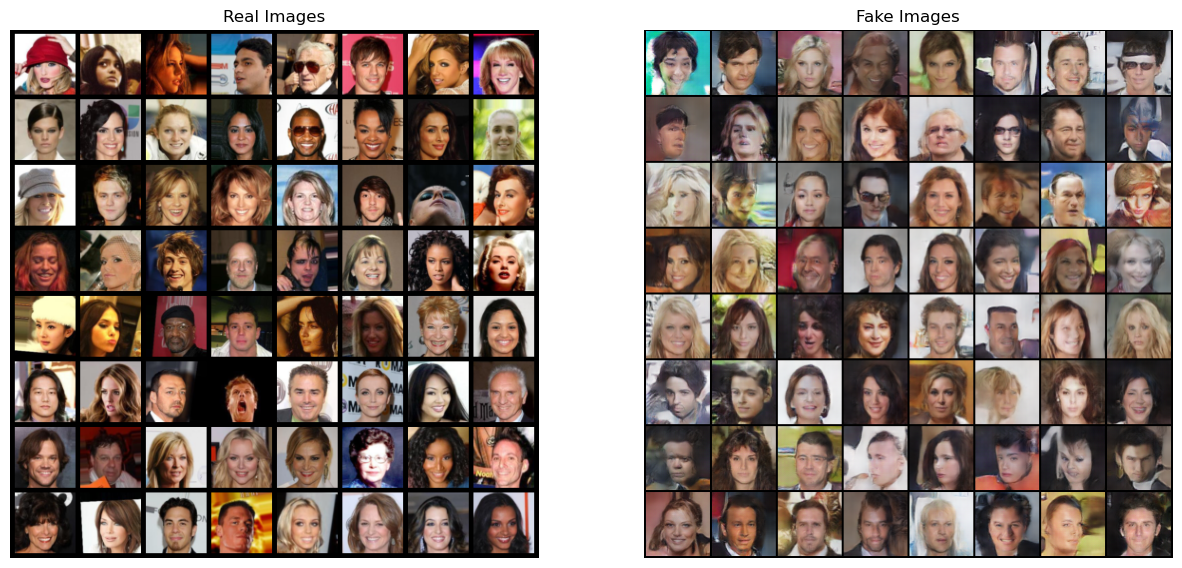

In [40]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()